# CNNs and transfer learning

## Introduction

In the past lab we have used the high-level API of PyTorch to implement an MLP. We have seen how shifted images produced significantly worse results, while to the human eye the examples are equally recognisable.

In this lab we will use convolutional layers to increase translation invariance of images. We will start with implementing a convolutional model to perform classification on MNIST and then we will load a pretrained model and use transfer learning on a new dataset of fish images.


## Objectives
- Learn to create a simple CNN model in PyTorch
- Use torch cuda device to improve training performance 
- Understand and perform transfer learning using pretrained models

## Getting started

We will first import all necessary modules:

In [90]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Convolutional neural network

In order to build a CNN we use Convolutional layers from PyTorch. In the case of images we will need 2D convolutions.

## Exercise 1

Implement the following model using PyTorch:

```
- convolutional 1 input channel (grayscale images), 6 output channels, kernel 5x5, stride 1x1
- rectified linear unit
- max pooling 2x2
- convolutional 6 input channels, 16 output channels, kernel 5x5, stride 1x1
- rectified linear unit
- max pooling 2x2
- flatten
- linear 120 output units
- rectified linear unit
- linear 84 output units
- rectified linear unit
- linear 10 output units
```

**Note:** we must provide the input dimension of the first linear layer. This will depend on how the convolutional and pooling layers have downsampled the input images. By carefully looking at the docs of PyTorch we can compute the output dimensions before the linear layer. The lazy way is: 
- put an arbitrary value
- print the shape of `x` after every operation
- run a forward on a single batch (you may obtain a single batch from a dataloader with `next(iter(my_dataloader))`
- check where it fails and correct the input dimension of that layer  

For now you may simply put your best guess and we will correct it after running the next cell.

In [91]:
class Net(nn.Module):
    #defines a PyTorch model called Net which is a convolutional neural network (CNN) using the PyTorch nn.Module class as the base class.
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            #The first line of the architecture is a 2D convolutional layer with 1 input channel, 6 output channels and a kernel of size 5x5.
            nn.Conv2d(1, 6, 5),
            #This is followed by a rectified linear unit (ReLU) activation function.
            nn.ReLU(),
            #and a 2x2 max pooling layer
            nn.MaxPool2d(2),
            #adds another convolutional layer with 6 input channels and 16 output channels with a kernel of size 5x5. 
            nn.Conv2d(6, 16, 5),
            #ReLU activation function
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            #nn.Flatten(1) is used, which means it will reshape the tensor to 1D array in the first dimension. 
            nn.Linear(256, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )   


    def forward(self, x):
        ### BEGIN SOLUTION
        return self.net(x)
        ### END SOLUTION
    #to check the output and input for these layers i usually use this code, but after make sure of true input and output i remove i to not print alot  
    # def forward(self, x):
    #     for i, layer in enumerate(self.net):
    #         x = layer(x)
    #         print(f"layer {i} output shape: {x.shape}")
    #     return x

model = Net()
print(model)

x = torch.randn((1, 1, 28, 28))
model(x)

Net(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


tensor([[-0.0297,  0.0113,  0.0731,  0.0947, -0.0421, -0.0525, -0.0767,  0.0545,
          0.0677,  0.0570]], grad_fn=<AddmmBackward0>)

## Exercise 2
Create the datasets and data loaders for the MNIST dataset as done in the previous lab. Take the first batch and run a forward of the model correcting the input dimension of the first `Linear` layer.

In [92]:
# Create a 'transforms.Compose' object, which allows you to stack multiple transformation functions together
transform = transforms.Compose(
    [
        # The first transformation function is 'transforms.ToTensor', which converts a PIL image to a PyTorch tensor
        transforms.ToTensor(),
        # The second transformation function is 'transforms.Normalize', which normalizes the image tensor
        # It takes two arguments, the mean and standard deviation of the normalization
        #The normalization formula is: (tensor - mean) / std.
        #So in this case, the normalization formula applied to each pixel in the tensor is: 
        #(pixel_value - 0.5) / 0.5, this will make the pixel value of the tensor to be in the range of [-1, 1]
        transforms.Normalize((0.5), (0.5))
    ])

# Import the MNIST dataset from the torchvision library
training_data = torchvision.datasets.MNIST(
    # specify the directory to save the data
    root="data/mnist",
    # specify that we want the training set
    train=True,
    # download the data if it's not already present
    download=True,
    # apply the transformation to convert to a PyTorch tensor
    transform=transforms.ToTensor()
)

# Import the MNIST dataset from the torchvision library
test_data = torchvision.datasets.MNIST(
    # specify the directory to save the data
    #root: the location where the data will be stored
    root="data/mnist",
    # specify that we want the test set
    train=False,
    # download the data if it's not already present
    download=True,
    # apply the transformation to convert to a PyTorch tensor
    transform=transforms.ToTensor()
)

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=True)
# Create a DataLoader for the training data, with a batch size of 1 and shuffling the data 
# so that it's fed to the model in random order each time

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
# Create a DataLoader for the test data, with a batch size of 1 and shuffling the data 
# so that it's fed to the model in random order each time


first_batch = next(iter(train_dataloader)) # Get the first batch of data from the training dataloader
out = model(first_batch[0]) # Pass the first batch of data through the model
print(out)

tensor([[-0.0179,  0.0168,  0.0209,  0.0837, -0.0585, -0.0606, -0.0876,  0.0329,
          0.0410,  0.0189]], grad_fn=<AddmmBackward0>)


## Exercise 3

Train the model as done in the previous lab. Given that epochs take longer to compute with these models, we will print the average loss value every 1000 iterations. Write the train function so that every 1000 iterations it prints the average loss over these past 1000 iterations.

In [93]:
def train_model(model, dataloader, optimizer, criterion, n_epochs=1):
    model.train()
        
    for epoch in range(n_epochs):
        running_loss = 0.
        running_examples = 0
        # Zero the gradients of the model
        with torch.no_grad():
            model.zero_grad()
        for i, batch in enumerate(dataloader):
            # Unpack the inputs and labels from the batch
            inputs, labels = batch
            # Zero the gradients of the optimizer
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            # Compute the loss
            loss = criterion(outputs, labels)
            # Backward pass
            loss.backward()
            # Accumulate the loss and number of examples
            running_loss += loss.item()
            running_examples += inputs.shape[0]
            # Print the loss every 1000 iterations
            if (i+1) % 1000 == 0:
                print(f'ep: {epoch: 3d}, it: {i: 5d}, loss: {running_loss/running_examples:.3f}')
                running_loss = 0.
                running_examples =0
            # Update the parameters
            optimizer.step()            


def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            # Unpack the data
            inputs, labels = data
            # Forward pass
            outputs = model(inputs)
            # Get the index of the highest energy
            predicted = torch.argmax(outputs.data, dim=1)
            # Update total and correct count
            # Increment the total count by the number of examples in the current batch
            total += labels.size(0)
            # For each example in the current batch, check if the predicted label is equal 
            # to the true label and if so, increment the correct count
            correct += (predicted == labels).sum()
    # calculate the accuracy and return its value
    accuracy = correct/total
    return accuracy

# Initialize the model
model = Net()
# Define the loss function as the cross entropy loss
criterion = nn.CrossEntropyLoss()
# Define the optimizer as Stochastic Gradient Descent with a learning rate of 0.001 and a momentum of 0.9
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the batch size for the data loader
batch_size = 16

# Create the data loader for the training set
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
# Create the data loader for the test set
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Train the model for 2 epochs
train_model(model, train_loader, optimizer, criterion, n_epochs=2)
# Evaluate the model on the test set
accuracy = evaluate_model(model, test_loader)
# Print the accuracy of the model on the test set
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

ep:   0, it:   999, loss: 0.144
ep:   0, it:  1999, loss: 0.106
ep:   0, it:  2999, loss: 0.028
ep:   1, it:   999, loss: 0.014
ep:   1, it:  1999, loss: 0.011
ep:   1, it:  2999, loss: 0.009
Accuracy of the network on the test images: 93.2%


We notice that the change in architecture improves the accuracy obtained on the test set. However we also notice the training and testing takes longer. Convolutions are operations that can benefit significantly from GPU processing.

We will now learn how to move the data and operations to the GPU device to take advantage of its benefits.

The first thing to do is to obtain the GPU `device` if available, falling back to the CPU if the GPU is not available. This can be done with the following statement:

```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
```

Then we may move the `nn.Module` that we want run in GPU:

```
model.to(device)
```

We must also move the data `inputs` and `labels` to the GPU before using them.

```
inputs, labels = inputs.to(device), labels.to(device)
```

**Note:** in Google's Collaboratory environment we may request running the Python kernel on a GPU. To do so go to the Menu > Runtime > Change runtime type. Only use this feature when needed to avoid using unnecessary ressources.

## Exercise 4

Re-train the model, this time on GPU.

In [94]:
def train_model(model, dataloader, optimizer, criterion, n_epochs=1, log_every=200, device='cpu'):
    # move model to the device (e.g. 'gpu')
    model = model.to(device)
    # set model to training mode
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        # zero the gradients of the model
        with torch.no_grad():
            model.zero_grad()
        for i, data in enumerate(dataloader):
            inputs, labels = data
            # move data to the device
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the gradients of the optimizer
            optimizer.zero_grad()
            # forward pass
            outputs = model(inputs)
            # compute loss
            loss = criterion(outputs, labels)
            # backpropagation
            loss.backward()
            # update parameters
            optimizer.step()
            # accumulate loss
            running_loss += loss.item()
            # print log message every log_every iterations
            if (i+1) % log_every == 0:
                print(f'[{epoch}, {i}] loss: {running_loss/log_every}')
                running_loss = 0.0


def evaluate_model(model, dataloader, device='cpu'):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            # Unpack the data
            inputs, labels = data
            # Forward pass
            inputs, labels = inputs.to(device), labels.to(device) # move data to device
            outputs = model(inputs)
            # Get the index of the highest energy
            predicted = torch.argmax(outputs.data, dim=1)
            # Update total and correct count
            # Increment the total count by the number of examples in the current batch
            total += labels.size(0)
            # For each example in the current batch, check if the predicted label is equal 
            # to the true label and if so, increment the correct count
            correct += (predicted == labels).sum()
    # calculate the accuracy and return its value
    accuracy = correct/total
    return accuracy


# Move device allocation to the top of script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer on device
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 16

train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device)
accuracy =evaluate_model(model, test_loader, device=device)

print(f'Accuracy of the network on the 10000 test images: {accuracy:.1%}')

[0, 199] loss: 2.3030282938480378
[0, 399] loss: 2.2983274626731873
[0, 599] loss: 2.2948795318603517
[0, 799] loss: 2.287786170244217
[0, 999] loss: 2.2703943240642546
[0, 1199] loss: 2.202502820491791
[0, 1399] loss: 1.5423884461820125
[0, 1599] loss: 0.7352803063392639
[0, 1799] loss: 0.5099849892407655
[0, 1999] loss: 0.46242942199110987
[0, 2199] loss: 0.363301050234586
[0, 2399] loss: 0.3122677761130035
[0, 2599] loss: 0.31042423914186656
[0, 2799] loss: 0.29615114357322453
[0, 2999] loss: 0.26757054854650053
[0, 3199] loss: 0.2643105295021087
[0, 3399] loss: 0.2166207100916654
[0, 3599] loss: 0.16906092822551727
[1, 199] loss: 0.17355837470386176
[1, 399] loss: 0.17222748481668532
[1, 599] loss: 0.2083472028071992
[1, 799] loss: 0.1655113333184272
[1, 999] loss: 0.17577239907346665
[1, 1199] loss: 0.14295104361372069
[1, 1399] loss: 0.14677549244835972
[1, 1599] loss: 0.14541123275645076
[1, 1799] loss: 0.14628737409366294
[1, 1999] loss: 0.14092616265639663
[1, 2199] loss: 0.11

In [95]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In this case the speed-up may not be too noticeable because the model is small. But we can now increase the number of convolutional filters without having a large impact on training time.

## Exercise 5

Try changing the number of filters of the first convolution to 16 and the next to 36.

In [96]:
class Net(nn.Module):
    #defines a PyTorch model called Net which is a convolutional neural network (CNN) using the PyTorch nn.Module class as the base class.
    def __init__(self):
        #The __init__ method initializes the model and defines the architecture of the network using PyTorch's nn.Sequential module.
        super().__init__()
        self.net = nn.Sequential(
            #The first line of the architecture is a 2D convolutional layer with 1 input channel, 16 output channels and a kernel of size 5x5.
            nn.Conv2d(1, 16, 5),
            nn.ReLU(),
            #the ReLU activation function sets all negative input values to zero and passes all other input values unchanged. f(x) = max(0, x)
            nn.MaxPool2d(2),
            #adds another convolutional layer with 6 input channels and 36 output channels with a kernel of size 5x5. 
            nn.Conv2d(16, 36, 5),
            #ReLU activation function
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            #nn.Flatten(1) is used, which means it will reshape the tensor to 1D array in the first dimension. 
            nn.Linear(36*4*4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )   


    def forward(self, x):
        ### BEGIN SOLUTION
        return self.net(x)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

[0, 199] loss: 2.300284413099289
[0, 399] loss: 2.2829023122787477
[0, 599] loss: 2.2361862015724183
[0, 799] loss: 1.8111659812927245
[0, 999] loss: 0.8689163457602262
[0, 1199] loss: 0.5607624227553606
[0, 1399] loss: 0.44954753410071135
[0, 1599] loss: 0.39233774825930595
[0, 1799] loss: 0.3489601518586278
[0, 1999] loss: 0.344130024202168
[0, 2199] loss: 0.25898753413930536
[0, 2399] loss: 0.23955883965827524
[0, 2599] loss: 0.2359600373916328
[0, 2799] loss: 0.22736918951384724
[0, 2999] loss: 0.2228412797814235
[0, 3199] loss: 0.21187179481610655
[0, 3399] loss: 0.17366435610922054
[0, 3599] loss: 0.1310338162747212
[1, 199] loss: 0.1474345665657893
[1, 399] loss: 0.13194035421940498
[1, 599] loss: 0.1692850247514434
[1, 799] loss: 0.12411842855159193
[1, 999] loss: 0.13579971497587395
[1, 1199] loss: 0.11301969352178276
[1, 1399] loss: 0.11347635576152243
[1, 1599] loss: 0.10976015802356415
[1, 1799] loss: 0.11456572261406109
[1, 1999] loss: 0.11667596909508575
[1, 2199] loss: 0

We will now test whether using CNN allows us to improve performance on the test set of shifted images. 

## Exercise 6
Create a new `test_shifted_set` and `test_shifted_loader` where images are shifted 3 pixels to the right and plot the first image. Use the transforms API of PyTorch (e.g. `transforms.Lambda`).

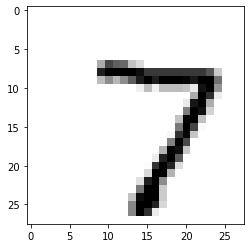

In [97]:
transform = transforms.Compose(
    [
        # The first transformation function is 'transforms.ToTensor', which converts a PIL image to a PyTorch tensor
        transforms.ToTensor(),
         # using transforms.Lambda and using torch.roll to apply the shif
        transforms.Lambda(lambda x: torch.roll(x, shifts=3))
    ])

#importing the MNIST dataset from the torchvision library, specifying that we want the test set 
test_shifted_set = torchvision.datasets.MNIST('data/mnist', download=True, train=False, transform=transform)
#loads the data in batches, with a specified batch size.
test_shifted_loader = torch.utils.data.DataLoader(test_shifted_set, batch_size=batch_size)
#displays the image
plt.imshow(test_shifted_set[0][0][0], cmap='gray_r')
plt.show()

## Exercise 7

Test the performance of the previously trained model on the new test set.

In [98]:
### BEGIN SOLUTION
#Test the performance of the previously trained model on the new shifted test set.
accuracy = evaluate_model(model, test_shifted_loader, device=device)
### END SOLUTION

print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Accuracy of the network on the test images: 70.6%


## [Optional] Exercise 8

Compare the performance of an MLP vs CNN for shifts of increasing number of pixels.

In [99]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256), # input layer with 784 input neurons and 256 output neurons
            nn.ReLU(), # apply ReLU activation function
            nn.Linear(256, 128), # hidden layer with 256 input neurons and 128 output neurons
            nn.ReLU(), # apply ReLU activation function
            nn.Linear(128, 10) # output layer with 128 input neurons and 10 output neurons (for the 10 classes)
        )

    def forward(self, x):
        x = torch.flatten(x,1)# reshape input to 1D array
        return self.net(x)

# initialize the model
MLP_model = MLP()

# set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MLP_model.parameters(), lr=0.001, momentum=0.9)

# train the model
train_model(MLP_model, train_loader, optimizer, criterion, n_epochs=2, device=device)

# evaluate the model on the test set
accuracy = evaluate_model(MLP_model, test_shifted_loader, device=device)

# print the accuracy
print(f'Accuracy of the MLP network on the test images: {accuracy:.1%}')


[0, 199] loss: 2.2641402328014375
[0, 399] loss: 2.084665532708168
[0, 599] loss: 1.6582265174388886
[0, 799] loss: 1.0692635521292686
[0, 999] loss: 0.8302663740515709
[0, 1199] loss: 0.6483311323821545
[0, 1399] loss: 0.5164770654588938
[0, 1599] loss: 0.4849884083122015
[0, 1799] loss: 0.46548719856888054
[0, 1999] loss: 0.4957045266777277
[0, 2199] loss: 0.40973373722285034
[0, 2399] loss: 0.3973682425543666
[0, 2599] loss: 0.3970214818418026
[0, 2799] loss: 0.38688790626823905
[0, 2999] loss: 0.3894436600618064
[0, 3199] loss: 0.392043398860842
[0, 3399] loss: 0.36370028387755154
[0, 3599] loss: 0.29838547378778457
[1, 199] loss: 0.3165655410848558
[1, 399] loss: 0.29273227451369166
[1, 599] loss: 0.34914681777358053
[1, 799] loss: 0.31032818380743266
[1, 999] loss: 0.355537047944963
[1, 1199] loss: 0.2931528507079929
[1, 1399] loss: 0.2882201844966039
[1, 1599] loss: 0.2950752239301801
[1, 1799] loss: 0.2975326416827738
[1, 1999] loss: 0.3262711235880852
[1, 2199] loss: 0.2721240

The accuracy of MLP is very low compared to CNN

## [Optional] Exercise 9

Propose a solution (and optionally implement it) to make the models even more robust to shifts?

Dropout: Using dropout layers can help prevent overfitting by randomly dropping out neurons during training, and as you will se you will find that the accuracy increased


we can also increasing the kernel size of the maxpooling layers to 3 we get a good acuracy
  
another method is editing the datasets

In [100]:
class Net_edit(nn.Module):
    #defines a PyTorch model called Net which is a convolutional neural network (CNN) using the PyTorch nn.Module class as the base class.
    def __init__(self):
        #The __init__ method initializes the model and defines the architecture of the network using PyTorch's nn.Sequential module.
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Dropout(0.25),
            nn.Conv2d(16, 36, 5),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Flatten(1),
            nn.Dropout(0.25),
            nn.Linear(36, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
            )


    def forward(self, x):
        ### BEGIN SOLUTION
        return self.net(x)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net_edit()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device)
accuracy = evaluate_model(model,  test_shifted_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

[0, 199] loss: 2.302383635044098
[0, 399] loss: 2.2965759110450743
[0, 599] loss: 2.2904098403453825
[0, 799] loss: 2.2785422897338865
[0, 999] loss: 2.259985589981079
[0, 1199] loss: 2.2177947521209718
[0, 1399] loss: 2.1166557186841963
[0, 1599] loss: 1.9106689834594726
[0, 1799] loss: 1.643493720293045
[0, 1999] loss: 1.435769036114216
[0, 2199] loss: 1.2543863907456398
[0, 2399] loss: 1.1101944741606713
[0, 2599] loss: 0.9976276713609695
[0, 2799] loss: 0.8916620054841041
[0, 2999] loss: 0.8244886733591557
[0, 3199] loss: 0.7263901606202126
[0, 3399] loss: 0.6622232466936111
[0, 3599] loss: 0.5923930260539055
[1, 199] loss: 0.5383983688056468
[1, 399] loss: 0.5102588371932506
[1, 599] loss: 0.5198470325395464
[1, 799] loss: 0.4408619195222855
[1, 999] loss: 0.4962560953199863
[1, 1199] loss: 0.4463812777400017
[1, 1399] loss: 0.3794479091651738
[1, 1599] loss: 0.4080575685575604
[1, 1799] loss: 0.38165427651256323
[1, 1999] loss: 0.4222371622361243
[1, 2199] loss: 0.367933527603745

# Transfer learning

It is quite rare that we implement new models from scratch, specially when our target dataset is small.

We will often perform what is known as transfer learning: **start from well-established models pre-trained on large quantities of similar data**. For example, for natural image related tasks we will often start from a `ResNet` or `MobileNet`, whose weights have been trained on a classification task on ImageNet.

The model chosen to base our work on is often referred to as the **backbone**.

Depending on the task the pre-trained model may not be directly usable. Even when performing a classification task, the classes may not be the same, even the number of classes may vary. Therefore, for sure the output layer of the model may need to be modified (and re-trained).

PyTorch provides pre-trained models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) and from [PyTorch Hub](https://pytorch.org/hub/). Throughout this lab we will use the PyTorch Hub way.

For instance to download a [ResNet-18 model](https://pytorch.org/hub/pytorch_vision_resnet/) we would do:

```
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
```

To practice the methodology of transfer learning, we will use a small dataset provided by [here](https://homepages.inf.ed.ac.uk/rbf/fish4knowledge/GROUNDTRUTH/RECOG/)

We will do the following steps:
1. Download the data and untar it
2. Create a dataset object using [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder)
3. Split the dataset into train and test using [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
4. Train several models on the data
    1. A simple custom made CNN model
    2. A ResNet-18 without pretrained weights
    3. A ResNet-18 with pretrained weights training only the last layer

When splitting the data into train and test we will do a 80% / 20% ratio per each class (stratified). <!--We notice in the dataset that consecutive images seem to be extracted often from the same video segment, therefore we will split data in consecutive chunks instead of shuffling it (random split).-->

## Exercise 10
Download the data and untar it. Using `wget` (run with the `-nc` flag to avoid redownloading unnecessarily multiple times) and `tar`. Bash commands in Colab and Jupyter must be preceded by a `!`.

In [130]:
### BEGIN SOLUTION

# Download the data
!wget -nc https://homepages.inf.ed.ac.uk/rbf/fish4knowledge/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar


### END SOLUTION

File ‘fishRecognition_GT.tar’ already there; not retrieving.



In [131]:
#Unpacks the fishRecognition_GT.tar file
!tar xf fishRecognition_GT.tar

tar: A lone zero block at 997875


## Exercise 11
Create a `torchvision.datasets.ImageFolder` for the full fish recognition dataset and plot the first example.

In [132]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=[0.4781, 0.6127, 0.5838], std=[0.2516, 0.3121, 0.3172]) #Normalize the image 
    ]
    )

### BEGIN SOLUTION
full_set = torchvision.datasets.ImageFolder('/content/fish_image', transform=transform)
### END SOLUTION

full_set.classes = [
                    'Dascyllus reticulatus',
                    'Plectroglyphidodon dickii',
                    'Chromis chrysura',
                    'Amphiprion clarkii',
                    'Chaetodon lunulatus',
                    'Chaetodon trifascialis',
                    'Myripristis kuntee',
                    'Acanthurus nigrofuscus',
                    'Hemigymnus fasciatus',
                    'Neoniphon sammara',
                    'Abudefduf vaigiensis',
                    'Canthigaster valentini',
                    'Pomacentrus moluccensis',
                    'Zebrasoma scopas',
                    'Hemigymnus melapterus',
                    'Lutjanus fulvus',
                    'Scolopsis bilineata',
                    'Scaridae',
                    'Pempheris vanicolensis',
                    'Zanclus cornutus',
                    'Neoglyphidodon nigroris',
                    'Balistapus undulatus',
                    'Siganus fuscescens'  	
]

In [104]:
print(len(full_set) )


27370


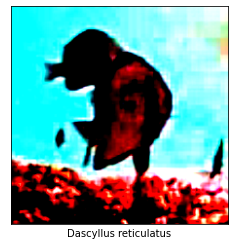

In [133]:
### BEGIN SOLUTION
# Get the first example from the dataset
img, label = full_set[0]

# Plot the image
plt.imshow(img.permute(1, 2, 0))

# Remove x and y axis ticks
plt.xticks([])
plt.yticks([])

# Add the label of the image as the x-axis label
plt.xlabel(full_set.classes[label])

# Show the plot
plt.show()

### END SOLUTION


## Exercise 12

Using the [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and the labels from `full_set.targets` perform a stratified random split.

Then create the two new datasets `train_set` and `test_set` using [`torch.utils.data.Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset)

In [134]:
# import the train_test_split function from scikit-learn
from sklearn.model_selection import train_test_split

# create a list of labels from the targets attribute of the full_set object
labels = list(full_set.targets)

# create an array of indices that correspond to the samples in the dataset
indices = np.arange(len(labels))

# import the Subset class from torch.utils.data
from torch.utils.data import Subset

# Use the train_test_split function to randomly split the dataset into two sets: a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(indices, labels, test_size=0.2, stratify=labels)

# Create two new datasets, one for the training set and one for the test set
train_set = Subset(full_set, X_train)
test_set = Subset(full_set, X_test)


In [113]:
# print the length of the train_set
print(len(train_set))

# print the length of the test_set
print(len(test_set))


21896
5474


## Exercise 13

Compute on a batch of 500 random samples the mean and std deviation for each of the RGB channels. Set these in the `Normalize` transform of the full dataset of the previous cells in order to obtain a normalized version of the dataset.

In [135]:
loader = torch.utils.data.DataLoader(train_set, batch_size=500, shuffle=True, num_workers=1)

sample = next(iter(loader)) # Get a sample of data from the training dataloader
print(sample[0].shape)

torch.Size([500, 3, 224, 224])


In [136]:
# Get a sample of data from the training dataloader
sample = next(iter(loader))

# Get the image data
images = sample[0]

# Compute the mean and std deviation for each channel
mean = images.mean(axis=(0, 2, 3))
std = images.std(axis=(0, 2, 3))

# Print the mean and std deviation
print(f'Mean: {mean}, Std deviation: {std}')

# Create a new transform with the computed mean and std deviation
normalize_transform = transforms.Normalize(mean=mean, std=std)

# Define the final transform applied to the full dataset
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize_transform
])

# Create a new version of the full dataset with the final transform
normalized_full_set = torchvision.datasets.ImageFolder('/content/fish_image', transform=transform)


Mean: tensor([-0.0445, -0.0111, -0.0264]), Std deviation: tensor([1.0056, 1.0109, 1.0071])


## Exercise 14

Before tackling transfer learning with an existing model, we will revisit the simple CNN and training procedure we built for MNIST earlier in this lab and make a few modifications.

1. We must first adapt the input to 3 channels (RGB)
2. Adapt the output of the network to the number of classes in our task
3. Increase the number of convolutional layers to 3 (we have larger images) with number of filters `[6, 16, 32]`
4. Adapt the number of inputs of the first fully connected layer
5. Increase the batch size to `64` to improve training time

In [123]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32*24*24, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )   

    def forward(self, x):
        return self.net(x)
def train_model(model, dataloader, optimizer, criterion, n_epochs=1, log_every=200, device='cpu'):
    # move model to the device (e.g. 'gpu')
    model = model.to(device)
    # set model to training mode
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        # zero the gradients of the model
        with torch.no_grad():
            model.zero_grad()
        for i, data in enumerate(dataloader):
            inputs, labels = data
            # move data to the device
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the gradients of the optimizer
            optimizer.zero_grad()
            # forward pass
            outputs = model(inputs)
            # compute loss
            loss = criterion(outputs, labels)
            # backpropagation
            loss.backward()
            # update parameters
            optimizer.step()
            # accumulate loss
            running_loss += loss.item()
            # print log message every log_every iterations
            if i % log_every == 0:
                print(f'[{epoch}, {i}] loss: {running_loss/log_every}')
                running_loss = 0.0

def evaluate_model(model, dataloader, device='cpu'):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            # Unpack the data
            inputs, labels = data
            # Forward pass
            inputs, labels = inputs.to(device), labels.to(device) # move data to device
            outputs = model(inputs)
            # Get the index of the highest energy
            predicted = torch.argmax(outputs.data, dim=1)
            # Update total and correct count
            # Increment the total count by the number of examples in the current batch
            total += labels.size(0)
            # For each example in the current batch, check if the predicted label is equal 
            # to the true label and if so, increment the correct count
            correct += (predicted == labels).sum()
    # calculate the accuracy and return its value
    accuracy = correct/total
    return accuracy


batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net(len(full_set.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

[0, 0] loss: 0.06183483600616455
[0, 50] loss: 2.5196905517578125
[0, 100] loss: 1.6261536288261413
[0, 150] loss: 1.2566120779514314
[0, 200] loss: 1.1091194450855255
[0, 250] loss: 1.0037060534954072
[0, 300] loss: 0.9680192053318024
[1, 0] loss: 0.01861480951309204
[1, 50] loss: 0.9148016047477722
[1, 100] loss: 0.8672262787818908
[1, 150] loss: 0.8188604360818863
[1, 200] loss: 0.7553543764352798
[1, 250] loss: 0.7735946381092071
[1, 300] loss: 0.6885336768627167
Accuracy of the network on the test images: 77.3%


We will now create two utility function to help us visualize the outputs of an image classification model.

## Exercise 15

Create a function that takes an image, a model and list of classes and plots the image and a horizontal bar plot (using [`plt.barh`](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html)) showing the probabilities assigned to the top 10 predicted classes (using [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html?highlight=topk#torch.topk)). Test it on the first image of the test set and using previous trained model.

**Note**: think of bringing back to the cpu and converting to numpy `my_np_array = my_torch_tensor.cpu().numpy()` torch tensors that are in the GPU.

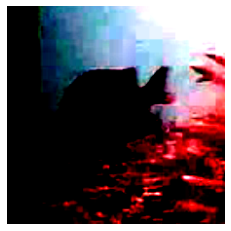

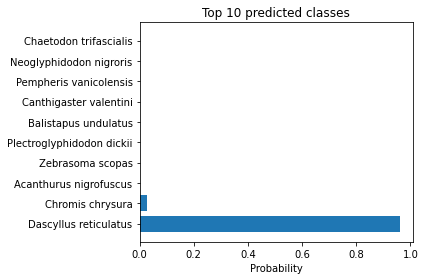

In [137]:
import matplotlib.pyplot as plt
import torch

def viz_image(image, model, classes, top=10, device='cpu'):
    assert image.ndim == 3, "Images are expected to have 3 dimensions: channels x height x width"
    was_training = model.training
    model.eval()

    with torch.no_grad():
        # move input image to desired device
        image = image.to(device)

        # add batch dimension
        image = image.unsqueeze(0)
        # forward pass
        output = model(image)
        # apply softmax function
        output = torch.softmax(output, dim=1)
        # move output to CPU
        output = output.cpu()
        # convert output to numpy
        output = output.numpy()
        # get the top-k predicted classes
        _, indices = torch.topk(torch.tensor(output), top)
        # get the top-k predicted probabilities
        probs = output[0][indices]
        top_classes = [classes[i] for i in indices.numpy().tolist()[0]]

    plt.figure()
    plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy())
    plt.axis("off")

    plt.figure()
    plt.barh(y=range(top), width=probs.flatten(), tick_label=top_classes)
    plt.xlabel("Probability")
    plt.title("Top {} predicted classes".format(top))

    plt.tight_layout()
    model.train(was_training)

image, label = test_set[0]
viz_image(image, model, full_set.classes, device=device)


## Exercise 16

Next we will visualize a batch of images and the class predicted by the model with it's probability in parentheses as their `xlabel`.
The function will also return the probabilites of all classes predicted for each image (tensor of `torch.float` with shape `(N, 1000)` where `N` is the number of images in the batch) and the class predicted by the model for each image (tensor of `torch.long` with shape `(N)`).

**Hint**: for create a grid of images consider the following snippet

```
fig = plt.figure(figsize=(10, 10))
for i, image in enumerate(images):
    ax = fig.add_subplot(n_rows, n_cols, i+1)

    # some code to normalize each image

    ax.imshow(...
```

**Note**: Normalize the pixels of each image between 0 and 1 before plotting it to obtain natural colors. Remember we need to do this, because each image was previously normalized to mean 0 and stddev 1 in order to be fed in the expected way by the model.

In [138]:
def viz_image_batch(images, model, classes, top=5, device='cpu', labels=None):
    """
    Visualize a batch of images and their predicted class by the model
    Parameters:
        images: a batch of images of shape (batch_size, channels, height, width)
        classes: a list of class labels
        top : the number of top predictions to display
       labels (torch.Tensor): the true labels of the images, used for comparison
    Returns:
       probs: the probability of each class for each image
       max_class: the top predicted class for each image
    """
    assert images.ndim == 4
    model.to(device)

    was_training = model.training
    model.eval()

    with torch.no_grad():
        images = images.to(device)
        output = model(images)
        probs = torch.softmax(output, dim=1)
        max_class, indices = torch.topk(output, top, dim=1)
        max_class = max_class.cpu()
        indices = indices.cpu()
        probs = probs.cpu()

    n_rows = int(np.ceil(images.size(0) ** 0.5))
    n_cols = int(np.ceil(images.size(0) / n_rows))
    fig = plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(images):
        # Create a subplot for each image
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        # Plot the image
        ax.imshow(image.permute(1, 2, 0).squeeze().cpu().numpy())
        ax.axis("off")
        if labels is not None:
            # Display the true label
            ax.set_title(f'True: {classes[labels[i]]}')
        # Display the predicted class and its probability
        ax.set_xlabel(f'Predicted: {classes[indices[i][0]]} ({probs[i][indices[i][0]]:.2f})')

    plt.tight_layout()
    model.train(was_training)

    return probs, max_class


(tensor([[9.6267e-01, 1.4808e-03, 2.7581e-02, 7.5380e-05, 4.1611e-05, 3.3234e-04,
          2.3364e-05, 2.8633e-03, 2.4647e-04, 1.7388e-05, 2.8137e-04, 4.2384e-04,
          1.7089e-04, 1.6014e-03, 9.8154e-05, 7.4228e-06, 1.2613e-04, 1.7508e-04,
          4.2309e-04, 6.9825e-05, 3.5058e-04, 8.4741e-04, 8.9161e-05],
         [5.8883e-02, 1.1165e-03, 8.4292e-07, 8.0243e-02, 2.9825e-06, 4.1949e-02,
          2.0465e-04, 3.9199e-06, 8.2967e-04, 6.6721e-01, 2.2951e-04, 8.3279e-02,
          3.2041e-03, 8.3354e-05, 1.1317e-03, 4.3846e-02, 1.0205e-03, 6.8020e-04,
          3.6640e-06, 1.5957e-02, 1.0654e-06, 2.1050e-05, 1.0260e-04],
         [6.0570e-01, 1.0936e-06, 3.9384e-01, 4.0720e-11, 5.5082e-13, 2.9807e-10,
          4.3738e-11, 4.2368e-04, 5.2902e-07, 5.9722e-14, 3.8735e-11, 2.0978e-09,
          2.0539e-09, 3.0987e-05, 1.9388e-11, 1.8835e-11, 6.0561e-12, 1.3424e-07,
          3.1209e-09, 2.2401e-10, 8.3729e-09, 7.7528e-08, 2.6627e-09],
         [9.1317e-01, 1.0857e-08, 8.6828e-02, 1.5

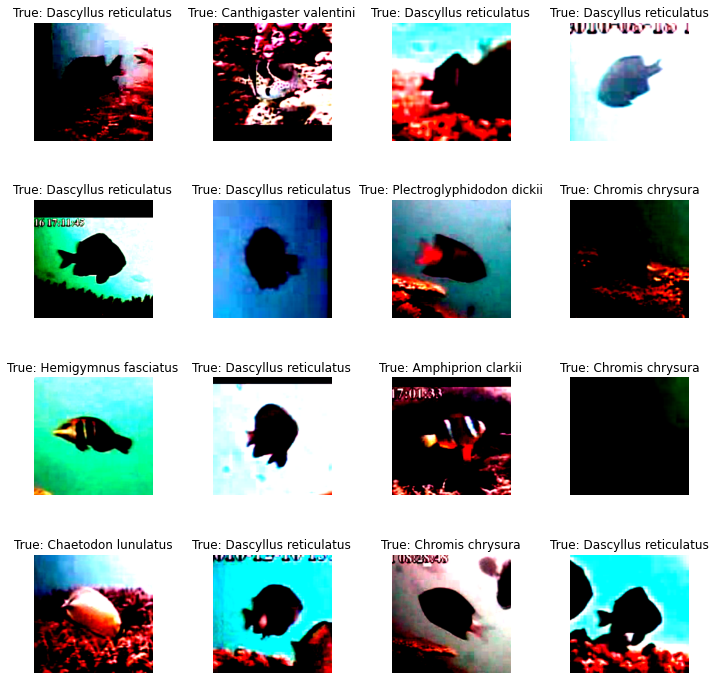

In [139]:
# test_loader is a DataLoader 
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

# Load a batch of images and corresponding labels from the test set using the test_loader
images, labels = next(iter(test_loader))

# Visualize the batch of images using the function viz_image_batch
viz_image_batch(images, model, full_set.classes, labels=labels, device=device)


# ResNet model

ResNets are a family of models that have been popularized by their performance in image classification tasks. We will start by downloading a [ResNet18 model](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet18) (a ResNet model composed of 18 layers). Other variants exist with varying number of layers: `resnet34`, `resnet50`, `resnet101`, `resnet152`.

When using an existing model with our particular task, we must first ensure that the inputs of the model are correctly matched.
- The images must have a size compatible with the model

In the case of resnet18, it expects images of size 224x224. In Exercise 11 we had created our datasets for the underwater images in a way that images were scaled (and cropped when necessary) to this size. 

```
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ...
    ]
```
- The images must have been normalised in an equal (or similar) way

In [torchvision documentation](https://pytorch.org/vision/stable/models.html#:~:text=All%20pre%2Dtrained,0.229%2C%200.224%2C%200.225%5D) we find that the models expect images to be normalized with zero mean and standard deviation of 1.  For the natural images in ImageNet, this corresponds to the following transform:

```
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
```

However in this lab we have recomputed the statistics of a subsample of our data, since underwater images may have significantly different statistics. 

- The output of the model may need to be modified to match our class set

At first we will not change the output, however the following exercises will require changing the final layer of the model to adapt to our own class set.

## Exercise 17
We will start by downloading a pre-trained `resnet18` and visualizing how it classifies our own images into the ImageNet classes.
**Note**: in order to show the class labels with which it was trained, we could download ImageNet using [`torchvision.datasets.ImageNet`](https://pytorch.org/vision/stable/datasets.html#imagenet) and access the `.classes` attribute of the dataset. However this would take a long unnecessary time and bandwidth, since only the labels are needed. PyTorch is currently revisiting the API of pretrained models ([see here](https://github.com/pytorch/vision/pull/4610)) to solve this and other issues. In the meantime we can download the class list from [https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt).  

In [26]:
#download the file "imagenet_classes.txt"
!wget -nc https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-01-19 22:41:06--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-01-19 22:41:06 (102 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [27]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [s.strip() for s in f.readlines()]

print(len(imagenet_classes))

1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


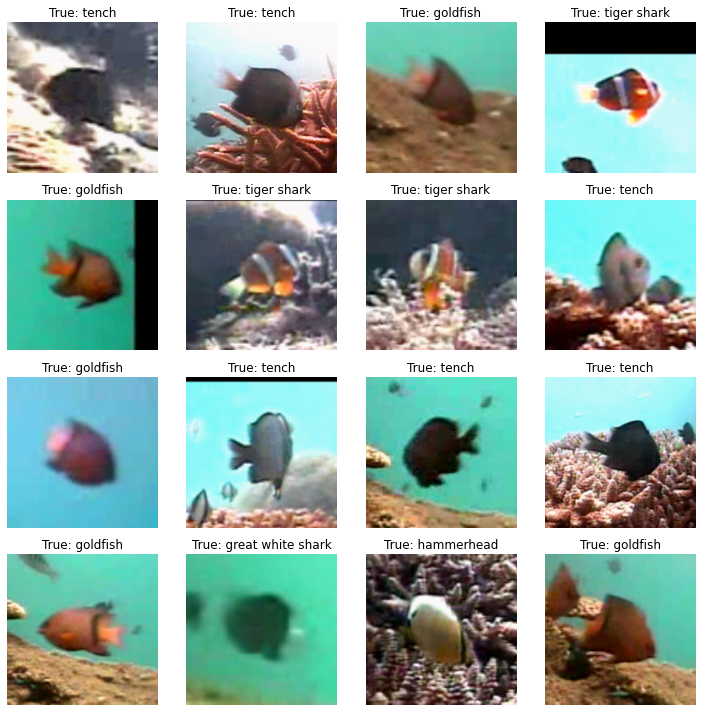

In [74]:
# load the pretrained model from PyTorch hub
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# create a test data loader
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

# get a batch of test images and their labels
images, labels = next(iter(test_loader))

# visualize the images and their predictions using the viz_image_batch function
probs, max_class = viz_image_batch(images, model, imagenet_classes, device=device, labels=labels)


the differnce is between the name of the classes

Your response here.

We are now going to explore different settings of reusing the resnet-18 model. We will start with a non-pretrained model, by initialising the weights randomly and training all layers using the standard training loop that we did before.

To achieve this our first step is to **replace the output layer** in order to output logits for the correct number of classes (those found in our data).

We will first print the resnet model and identify the last layer.

## Exercise 19

Print a non-pretrained resnet18 model and identify the name of the output layer.

In [80]:
### BEGIN SOLUTION
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
print(model)
### END SOLUTION

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


`fc` stands for Fully Connected, and it is the last layer in the model.

In order to replace it we must first remember it's input dimensionality, which can be obtained using `fc.in_features`.

## Exercise 20

Replace the `fc` layer of the vanilla resnet-18 by another `Linear` layer with as many outputs as classes in our fish dataset. Train the resulting model for 2 epochs and show the obtained accuracy.

In [81]:
# load resnet18 model from pytorch hub and set it to not pre-trained
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
# change the last fully connected layer to have the number of output as the number of classes in our dataset
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(imagenet_classes))

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
batch_size = 64
# create data loaders for sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

# train the model for 2 epochs and log the progress every 50 batches
train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)

# evaluate the model on the test set
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[0, 0] loss: 0.1459803295135498
[0, 50] loss: 2.91980034828186
[0, 100] loss: 1.3692031729221343
[0, 150] loss: 1.0549056720733643
[0, 200] loss: 0.8698791551589966
[0, 250] loss: 0.8016346108913421
[0, 300] loss: 0.7298978042602539
[1, 0] loss: 0.008573858737945557
[1, 50] loss: 0.620571858882904
[1, 100] loss: 0.591585339307785
[1, 150] loss: 0.5427124419808388
[1, 200] loss: 0.4863881480693817
[1, 250] loss: 0.49496969699859616
[1, 300] loss: 0.46284943997859956
Accuracy of the network on the test images: 84.9%


## Exercise 21

We will now try to leverage the large amount of natural imaging data from ImageNet, by using as backbone a pretrained resnet18 as starting point for training.


In [82]:
# load resnet18 model from pytorch hub and set it to pre-trained
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

### BEGIN SOLUTION
# change the last fully connected layer to have the number of output as the number of classes in our dataset
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(imagenet_classes))

### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[0, 0] loss: 0.13969602584838867
[0, 50] loss: 2.2880608904361726
[0, 100] loss: 0.7344200694561005
[0, 150] loss: 0.5075313454866409
[0, 200] loss: 0.3757286649942398
[0, 250] loss: 0.3357005925476551
[0, 300] loss: 0.2617157280445099
[1, 0] loss: 0.0008916647732257843
[1, 50] loss: 0.18823522247374058
[1, 100] loss: 0.17203207775950433
[1, 150] loss: 0.13538807235658168
[1, 200] loss: 0.12652075309306382
[1, 250] loss: 0.14350843861699103
[1, 300] loss: 0.11199899636209011
Accuracy of the network on the test images: 97.8%


## Exercise 22
In some situations it may be faster and better in terms of acheived accuracy, to only train the last layer, while letting all other layers with their pretrained weights. To freeze a layer you may simply set the `require_grad` attribute of its parameters to `False`.

Sometimes it is still beneficial to perform an additional training phase in which all weights are updated for a couple of epochs. This is known as **fine tuning**. In this exercise we will only be training the inserted layer.

Implement this method and visualize the results on the first batch of test.

**Note**: You may iterate over all parameters of a model calling its `.parameters()` method.

**Note**: Make sure to not freeze the latest layer that you added.


In [83]:
# load resnet18 model from pytorch hub and set it to  pre-trained
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    
### BEGIN SOLUTION
# Get a list of all the parameters of the model
params = [i for i in model.parameters()]

# Freeze all layers of the pre-trained model except the last one
for idx in range(len(params)-2):
    params[idx].requires_grad = False

# Change the last fully connected layer to have the number of output as the number of classes in our dataset
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(imagenet_classes))
### END SOLUTION

# Set the optimizer to only update the parameters of the newly added linear layer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()


batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[0, 0] loss: 0.14792364120483398
[0, 50] loss: 2.741372358798981
[0, 100] loss: 1.2153976666927337
[0, 150] loss: 0.952612680196762
[0, 200] loss: 0.8048800539970398
[0, 250] loss: 0.7646945732831955
[0, 300] loss: 0.6938526898622512
[1, 0] loss: 0.006344514489173889
[1, 50] loss: 0.6061733573675155
[1, 100] loss: 0.5986110532283783
[1, 150] loss: 0.5584754699468613
[1, 200] loss: 0.5216008108854294
[1, 250] loss: 0.5440438768267631
[1, 300] loss: 0.5041573631763459
Accuracy of the network on the test images: 87.7%


After freezing all layers of a pre-trained model except the last one it affects on the accuracy and made it decrease it (This is because the pre-trained model has been trained on a large dataset and its parameters have learned useful features that can be useful for the new dataset as well). So to increase the accuracy we have to increase the epochs.

## Exercise 23

Visualize the first batch of 16 images and it's predicted class in test.

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


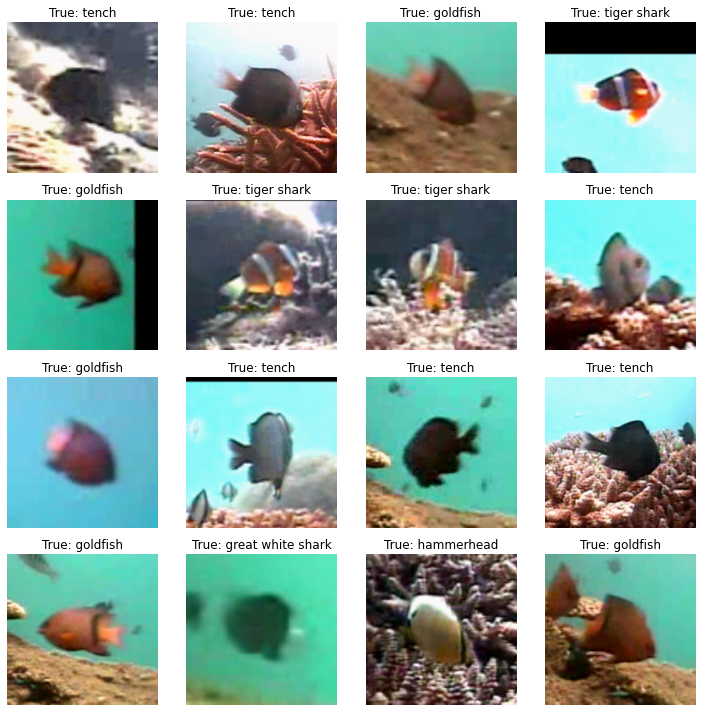

In [85]:

# load the pretrained model from PyTorch hub
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# create a test data loader
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

# get a batch of test images and their labels
images, labels = next(iter(test_loader))

# visualize the images and their predictions using the viz_image_batch function
probs, max_class = viz_image_batch(images, model, imagenet_classes, device=device, labels=labels)

## (optional) Exercise 24

Try with one (or all) of the following backbones: [`AlexNet`](https://pytorch.org/hub/pytorch_vision_alexnet/), [`VGG`](https://pytorch.org/hub/pytorch_vision_vgg/), [`MobileNetV2`](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/)

In [34]:
### BEGIN SOLUTION
# Load the pretrained VGG11 model from torchhub
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
print(model)
# Replace the last linear layer of the classifier with a new linear layer with number of output features equals to len(imagenet_classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, out_features=len(imagenet_classes))

### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')
# ### END SOLUTION

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [35]:
### BEGIN SOLUTION
# Load the pretrained alexnet model from torchhub
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
print(model)
# Replace the last linear layer of the classifier with a new linear layer with number of output features equals to len(imagenet_classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, out_features=len(imagenet_classes))

### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')
# ### END SOLUTION

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [36]:
### BEGIN SOLUTION
# Load the pretrained mobilenet_v2 model from torchhub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
print(model)
# Replace the last linear layer of the classifier with a new linear layer with number of output features equals to len(imagenet_classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, out_features=len(imagenet_classes))

### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')
# ### END SOLUTION


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## (optional) Exercise 25

Perform fine tuning on one (or more) of the models we have done.

In [37]:
# load resnet18 model from pytorch hub and set it to  pre-trained
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
    
### BEGIN SOLUTION
# Get a list of all the parameters of the model
params = [i for i in model.parameters()]

# Freeze all layers of the pre-trained model except the last one
for idx in range(len(params)-2):
    params[idx].requires_grad = False
#Replace the last linear layer of the classifier with a new linear layer with number of output features equals to len(imagenet_classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, out_features=len(imagenet_classes))
### END SOLUTION

# Set the optimizer to only update the parameters of the newly added linear layer
optimizer = optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)

# Train and evaluate the model
criterion = nn.CrossEntropyLoss()

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[0, 0] loss: 0.14655165672302245
[0, 50] loss: 1.7313902008533477
[0, 100] loss: 0.5366722732782364
[0, 150] loss: 0.4483096864819527
[0, 200] loss: 0.40620715618133546
[0, 250] loss: 0.3503334936499596
[0, 300] loss: 0.3322921448945999
[1, 0] loss: 0.005486948490142822
[1, 50] loss: 0.3117152984440327
[1, 100] loss: 0.2957959930598736
[1, 150] loss: 0.28259001672267914
[1, 200] loss: 0.2757624867558479
[1, 250] loss: 0.2544077345728874
[1, 300] loss: 0.27207511007785795
Accuracy of the network on the test images: 94.8%


In [38]:
# load vgg11model from pytorch hub and set it to  pre-trained
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
### BEGIN SOLUTION
# Get a list of all the parameters of the model
params = [i for i in model.parameters()]

# Freeze all layers of the pre-trained model except the last one
for idx in range(len(params)-2):
    params[idx].requires_grad = False
#Replace the last linear layer of the classifier with a new linear layer with number of output features equals to len(imagenet_classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, out_features=len(imagenet_classes))
### END SOLUTION
# Set the optimizer to only update the parameters of the newly added linear layer
optimizer = optim.SGD(model.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Train and evaluate the model
criterion = nn.CrossEntropyLoss()


batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[0, 0] loss: 0.1431438159942627
[0, 50] loss: 2.838820834159851
[0, 100] loss: 1.2245484828948974
[0, 150] loss: 0.9607248216867447
[0, 200] loss: 0.8450626015663147
[0, 250] loss: 0.7088008320331574
[0, 300] loss: 0.659337208867073
[1, 0] loss: 0.00994579553604126
[1, 50] loss: 0.6382176756858826
[1, 100] loss: 0.5770766323804856
[1, 150] loss: 0.5484002551436424
[1, 200] loss: 0.5449950629472733
[1, 250] loss: 0.49078677743673327
[1, 300] loss: 0.47507984161376954
Accuracy of the network on the test images: 89.5%


In [39]:
# load vgg11model from pytorch hub and set it to  pre-trained
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)    
### BEGIN SOLUTION
# Get a list of all the parameters of the model
params = [i for i in model.parameters()]

# Freeze all layers of the pre-trained model except the last one
for idx in range(len(params)-2):
    params[idx].requires_grad = False
#Replace the last linear layer of the classifier with a new linear layer with number of output features equals to len(imagenet_classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, out_features=len(imagenet_classes))
### END SOLUTION

# Train and evaluate the model
criterion = nn.CrossEntropyLoss()
# Set the optimizer to only update the parameters of the newly added linear layer
optimizer = optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[0, 0] loss: 0.13918478965759276
[0, 50] loss: 2.4267239892482757
[0, 100] loss: 0.9799362820386887
[0, 150] loss: 0.778319445848465
[0, 200] loss: 0.6687386679649353
[0, 250] loss: 0.5746559089422226
[0, 300] loss: 0.551005477309227
[1, 0] loss: 0.007510128021240234
[1, 50] loss: 0.536995244026184
[1, 100] loss: 0.4872607699036598
[1, 150] loss: 0.47238130658864974
[1, 200] loss: 0.46221978276968
[1, 250] loss: 0.42265552580356597
[1, 300] loss: 0.41208843111991883
Accuracy of the network on the test images: 91.3%
